In [1]:
import numpy as np
import tensorflow as tf
import gym
import tqdm
from collections import deque
import statistics

2023-03-09 14:00:19.545135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 14:00:19.625995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 14:00:19.626011: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 14:00:20.007790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
env = gym.make("CartPole-v1")
eps = np.finfo(np.float32).eps.item()

initial_state, _ = env.reset()
initial_state_shape = initial_state.shape

n_hidden_unit = 32
action_space = env.action_space.n
gamma = 1.01 # do not discount. This make sure the return[0] in loss help furthur reduce loss.
lr = 0.01

# define model

In [3]:
def get_model():
    """
    Given the state
    return the value for each action space
    """
    inputs = tf.keras.layers.Input(shape=initial_state_shape)
    dense = tf.keras.layers.Dense(64, activation="relu", name="hidden1")(inputs)
    dense = tf.keras.layers.Dense(128, activation="relu", name="hidden2")(dense)
#     dense = tf.keras.layers.Dense(32, activation="relu", name="hidden3")(dense)
    outputs = tf.keras.layers.Dense(action_space, activation=None, name="output")(dense)
    return tf.keras.Model(inputs, outputs)

model = get_model()

2023-03-09 14:00:20.545511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 14:00:20.545678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 14:00:20.545711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-09 14:00:20.545736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-09 14:00:20.545760: W tensorflow/c

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 hidden1 (Dense)             (None, 64)                320       
                                                                 
 hidden2 (Dense)             (None, 128)               8320      
                                                                 
 output (Dense)              (None, 2)                 258       
                                                                 
Total params: 8,898
Trainable params: 8,898
Non-trainable params: 0
_________________________________________________________________


# training data collection

In [5]:
def env_next(action):
    """
    wrap the python function into tf function
    """
    state, reward, done, _, _ = env.step(action)
    return (
        state.astype(np.float32), 
        np.array(reward, dtype=np.float32),
        np.array(done, dtype=np.int32)
    )

def tf_env_next(action):
    return tf.numpy_function(env_next, [action], [tf.float32, tf.float32, tf.int32])

def run_step(start_state, cur_step_in_epoch, model, step_length):
    """
    start_state: the start state of the env
    model: model
    max_steps_per_epoch: the number of max steps in an epoch
    cur_step_in_epoch: the current steps in this epoch
    step_length: how many steps to collect to update the weights
    """
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    actions = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    state = start_state
    for t in tf.range(step_length):
        state = tf.expand_dims(state, 0)
        value_output = model(state)
        action = tf.math.argmax(tf.squeeze(value_output))
        value = value_output[0, action]
        
        state, reward, done = tf_env_next(action)
        state.set_shape(initial_state_shape)
        
        rewards = rewards.write(t, reward)
        values = values.write(t, value)
        actions = actions.write(t, tf.cast(action, tf.int32))
        
        done = tf.cast(done, tf.bool)
        
        cur_step_in_epoch += 1
        if done:
            break
    
    
    last_value = model(tf.expand_dims(state, 0))
    max_last_value = tf.math.reduce_max(tf.squeeze(last_value))
       
    rewards = rewards.stack()
    values = values.stack()
    actions = actions.stack()
    return rewards, values, actions, done, cur_step_in_epoch, state, max_last_value
    
        
        
        
        

## test output

In [6]:
initial_state, _ = env.reset()
A = run_step(initial_state, tf.constant(0), model, 550)
A

/home/wei/anaconda3/envs/tf_211/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(<tf.Tensor: shape=(9,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>,
 <tf.Tensor: shape=(9,), dtype=float32, numpy=
 array([0.01136482, 0.08942429, 0.18420097, 0.27893737, 0.37431628,
        0.470115  , 0.5670238 , 0.66536665, 0.7659504 ], dtype=float32)>,
 <tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 <tf.Tensor: shape=(), dtype=int32, numpy=9>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.17501114,  1.7144957 , -0.22205749, -2.7993152 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.86882097>)

# calculate return

In [7]:
def calculate_return(rewards, normalize=tf.constant(True)):
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    returns = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for t in tf.range(tf.shape(rewards)[0]-1, -1, -1):
        discounted_sum = gamma * discounted_sum + rewards[t]
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(t, discounted_sum)
    returns = returns.stack()
    if normalize:
        pass
#         #1. method 1 - which does not work
#         returns = (returns - tf.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps)
    return returns

# TODO need to update the return according the step length

## test output

In [8]:
calculate_return(A[0])

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([9.368527 , 8.285671 , 7.2135353, 6.152015 , 5.101005 , 4.060401 ,
       3.0300999, 2.01     , 1.       ], dtype=float32)>

# calculate loss

In [9]:
"""
assume time step to update is T
Q(St, At) = Q(St+T+1, At+T+1) + (Ut - Ut+T+1)
where Ut - Ut+T is the rewards between timestamp t, t+1, t...t+T

Q(St, At) - Q(St+T+1, At+T+1)  approximate=  (Ut - Ut+T)
"""



loss_func = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM)
def compute_loss(values, qt_next, returns, actions):
    """
    values: estimated values, output by model
    qt_next: the estimate value for timestamp t+T+1
    returns: actual returns
    """

    loss = loss_func(tf.expand_dims(values[0]- qt_next, 0), tf.expand_dims(returns[0], 0))
    """
    below is very important. As the agent gets stronger, the T increases and as a result the loss above
    get larger. Meaning when T increases, by nature the loss increases. However, when T increases, it is what
    we want to see, and we need to reduce loss when T increases.
    """
    
    loss = loss / (tf.math.pow(1.0 + tf.math.abs(returns[0]), 2.0) + eps)
    return loss








    
    

## test output

In [10]:
initial_state, _ = env.reset()
A = run_step(initial_state, tf.constant(0), model, 550)

compute_loss(A[1], A[-1], calculate_return(A[0]), A[2])

<tf.Tensor: shape=(), dtype=float32, numpy=0.09536907>

# Train Step

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

@tf.function
def train_step(start_state, cur_step_in_epoch, model, step_length, optimizer):
    with tf.GradientTape() as tape:
        # 1. run step
        R = run_step(start_state=start_state, cur_step_in_epoch=cur_step_in_epoch, model=model, step_length=step_length)
        rewards, values, actions, done, cur_step_in_epoch, state, max_last_value = R
        
        # 2. calculate loss
        loss = compute_loss(values, max_last_value, calculate_return(rewards), actions)
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    return R, loss

## test output

In [12]:
initial_state, _ = env.reset()
R, loss = train_step(initial_state, 0, model, 550, optimizer)

# Run

In [13]:
max_epoches = 10000
min_epoches = 100
max_steps_per_epoch = 1500
step_length = 2000
rewards_thread = 1000
t = tqdm.trange(max_epoches)
running_rewards = deque(maxlen=min_epoches)
running_losses = deque(maxlen=min_epoches)
epoch_rewards_list = []
epoch_running_rewards_list = []
epoch_running_loss_list = []
loss_list = []


for i in t:
    initial_state, _ = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    start_state = initial_state
    cur_step_in_epoch = 0
    epoch_rewards = 0
    while True:
        R, loss = train_step(start_state, cur_step_in_epoch, model, step_length, optimizer)
        rewards, values, actions, done, cur_step_in_epoch, start_state, max_last_value = R
        start_state = tf.constant(start_state, dtype=tf.float32)
        epoch_rewards += int(tf.reduce_sum(rewards))
        if done or cur_step_in_epoch >= max_steps_per_epoch:
            break
#     print(i,actions)
    running_rewards.append(epoch_rewards)
    epoch_rewards_list.append(epoch_rewards)
    loss_list.append(float(loss))
    running_losses.append(float(loss))
    
    running_reward = statistics.mean(running_rewards)
    running_loss = statistics.mean(running_losses)
    epoch_running_rewards_list.append(running_reward)
    epoch_running_loss_list.append(running_loss)
    t.set_postfix(epoch_rewards=epoch_rewards, running_reward=running_reward)
    if i > min_epoches and running_reward > rewards_thread:
        break

        


  5%|▍         | 462/10000 [00:38<13:23, 11.86it/s, epoch_rewards=2000, running_reward=1012.61]  


In [14]:
start_state, _ = env.reset()
model(tf.expand_dims(start_state, 0))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 14.258127, -16.810349]], dtype=float32)>

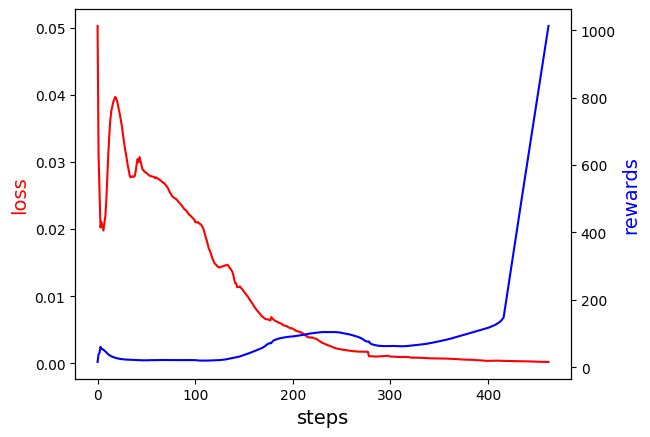

In [15]:
import matplotlib.pyplot as plt
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(range(len(epoch_running_loss_list)),
        epoch_running_loss_list,
        color="red")
# set x-axis label
ax.set_xlabel("steps", fontsize = 14)
# set y-axis label
ax.set_ylabel("loss",
              color="red",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(len(epoch_running_rewards_list)), epoch_running_rewards_list, color="blue")
ax2.set_ylabel("rewards",color="blue",fontsize=14)
plt.show()

# Visualization

In [16]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]

  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    values = model(state)
    action = np.argmax(values)

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(render_env, model, max_steps_per_epoch)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


/home/wei/anaconda3/envs/tf_211/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



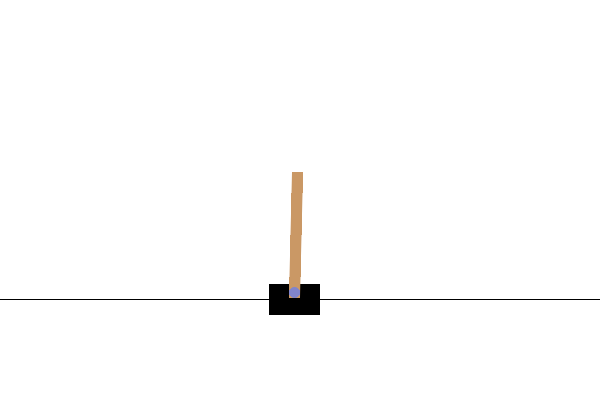

In [17]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)